# Train-test of single PINN poisson

In [1]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
import sys
from tqdm import tqdm
from utils import data_path
from base_network import neural_network
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory, crude_rel_L2
from jax.nn import sigmoid
import plotutils

In [2]:
file = data_path / "poisson_single_pinn_train.json"
file_test = data_path / "poisson_single_pinn_test.json"
activation = np.tanh

### Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [3]:
### Set RHS
def rhs(x):
    return np.where((x[0]>= 0.25) &(x[0]<=0.75)&(x[1]>= 0.25) &(x[1]<=0.75), -1,0)

In [4]:
# Set losses
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(p0, 0, weight = 20)
p0.interior_loss = interior_loss_factory(p0, rhs, weight = 1)
p0.create_loss()
xpinn.set_loss()


In [5]:
shapes = [[2, 20, 20, 20, 20, 20, 20, 20, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(exponential_decay)

    pinn.init_params(shape, optimizer)

In [6]:
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 0.48430371284484863
10.00% iter = 20000 of 200000: Total loss = 0.002893053228035569
20.00% iter = 40000 of 200000: Total loss = 0.0011271453695371747
30.00% iter = 60000 of 200000: Total loss = 0.0008931142510846257
40.00% iter = 80000 of 200000: Total loss = 0.000834147387649864
50.00% iter = 100000 of 200000: Total loss = 0.0007804071647115052
60.00% iter = 120000 of 200000: Total loss = 0.0007313918904401362
70.00% iter = 140000 of 200000: Total loss = 0.0006857417174614966
80.00% iter = 160000 of 200000: Total loss = 0.0006433286471292377
90.00% iter = 180000 of 200000: Total loss = 0.0006036820122972131
100.00% iter = 200000 of 200000: Total loss = 0.0005665331264026463


(1, 200000)
0.4843037
0.4843037


Text(0.5, 1.0, 'Loss per Pinn over 200000 epochs')

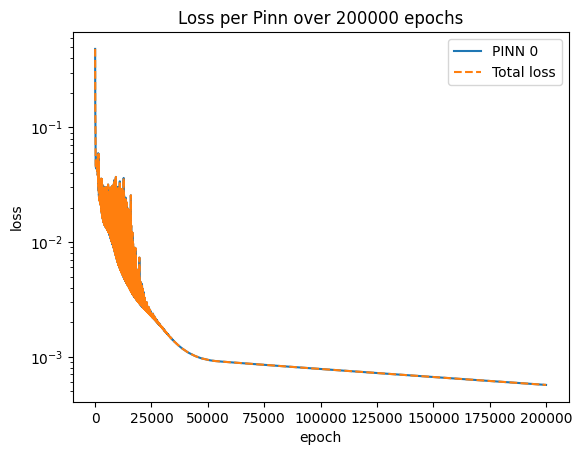

In [7]:
import matplotlib.pyplot as plt

a_losses = np.asarray(losses)
t_0 = 0
t = np.arange(t_0, n_iter)
print(a_losses.shape)
for i in range(2):
    print(a_losses[i,t_0])

for i in range(1):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

In [1]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="turbo")
    #plt.clim(min_, max_)
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution")
plt.colorbar()

NameError: name 'xpinn' is not defined

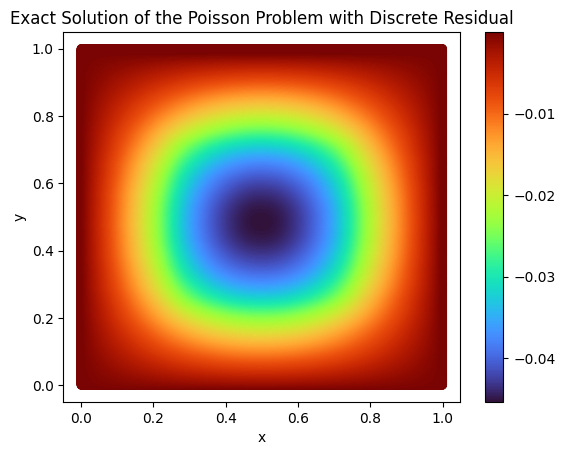

In [9]:
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=true_sol, cmap="turbo")
    plt.title("Exact Solution of the Poisson Problem with Discrete Residual")
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.clim(0, 1)

plt.colorbar()

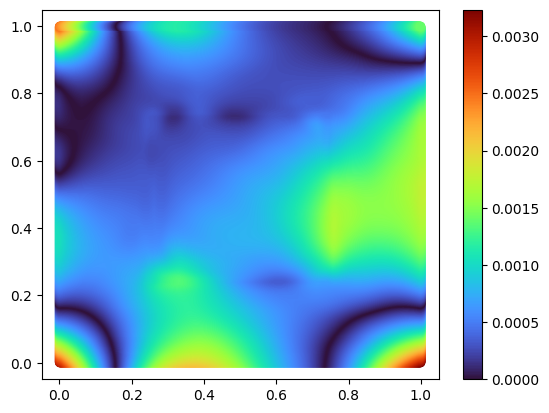

In [10]:
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=np.abs(true_sol-pred), cmap="turbo")

plt.title("Absolute Error for the PINN Solution")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

In [11]:
print(xpinn.PINNs[0].interior.shape)

(900, 2)
